In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch.utils.data import TensorDataset, random_split, DataLoader
import torchvision.transforms as transforms
import h5py

c:\Users\samhe\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


## Task 1: CNNs for Galaxy Classification

In [ ]:
# create data folder if it does not exist
import os
os.makedirs("data", exist_ok=True)

import urllib.request
_, msg = urllib.request.urlretrieve(
    "http://www.astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5", 
    "data/Galaxy10.h5"
)

In [2]:
label_names = [
    'Disk, Face-on, No Spiral',
    'Smooth, Completely round',
    'Smooth, in-between round',
    'Smooth, Cigar shaped',
    'Disk, Edge-on, Rounded Bulge',
    'Disk, Edge-on, Boxy Bulge',
    'Disk, Edge-on, No Bulge',
    'Disk, Face-on, Tight Spiral',
    'Disk, Face-on, Medium Spiral',
    'Disk, Face-on, Loose Spiral'
]
n_classes = len(label_names)

# To get the images and labels from file
with h5py.File('data/Galaxy10.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])
images = images.astype(np.float32)

# comply to (batch, channel, height, width) convention of pytorch
images = np.moveaxis(images, -1, 1)  
# convert to torch
images = torch.from_numpy(images)
labels = torch.from_numpy(labels)

print(f'{images.shape=}, {labels.shape=}')

images.shape=torch.Size([21785, 3, 69, 69]), labels.shape=torch.Size([21785])


### (a)

In [3]:
norm_images = images / 255

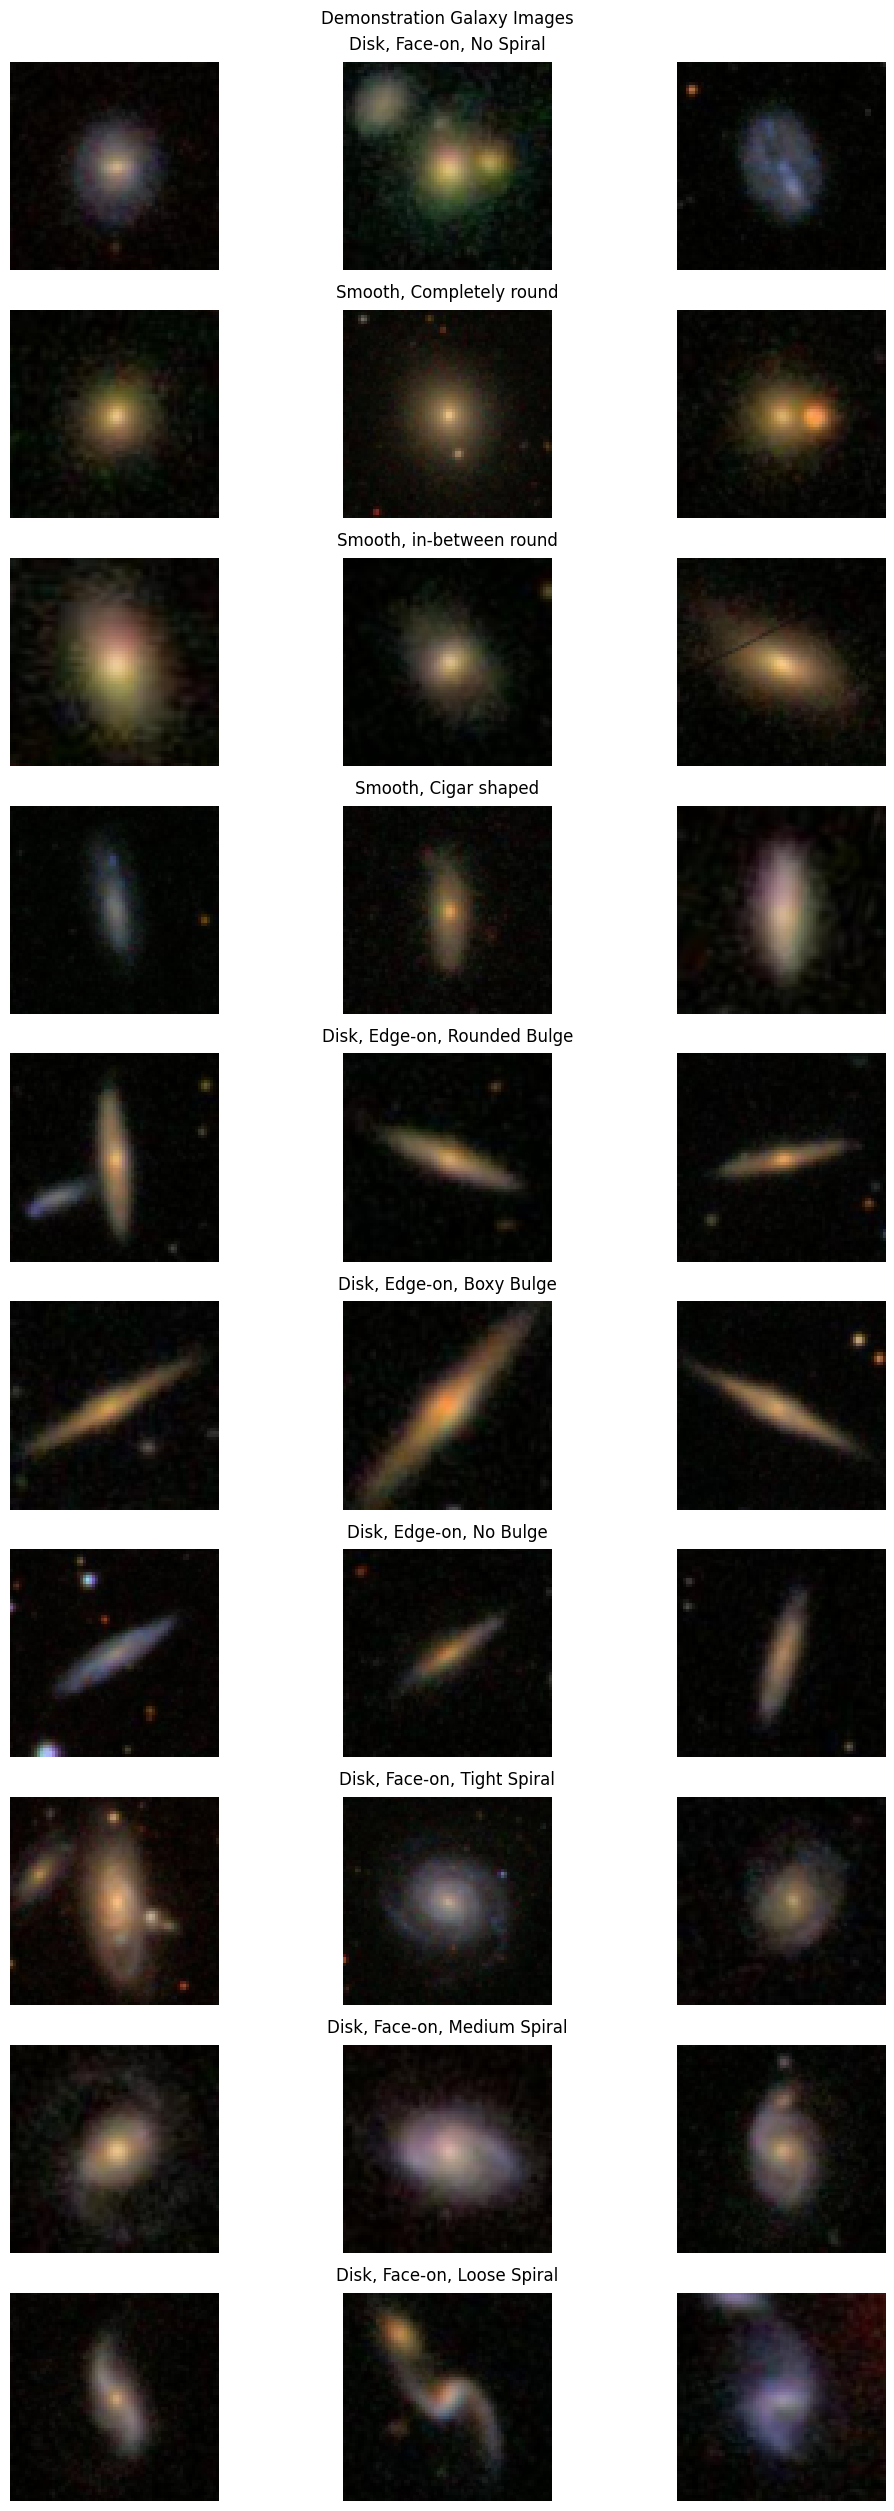

In [4]:
fig = plt.figure(constrained_layout=True, figsize=(10, 25))
fig.suptitle('Demonstration Galaxy Images')

# create 3x1 subfigs
subfigs = fig.subfigures(nrows=n_classes, ncols=1)  # Adjusted to match intent
for row, subfig in enumerate(subfigs):
    subfig.suptitle(f'{label_names[row]}')  # Correct usage
    axs = subfig.subplots(1, 3)  # Create 1x3 axes within the subfigure
    for col, ax in enumerate(axs):
        ax.imshow(norm_images[labels == row][col].permute(1, 2, 0)) #CHW to HWC
        ax.axis('off')
plt.show()


In [5]:
# Compute channel wise means and stds
mean = images.mean(dim=(0, 2, 3))
std = images.std(dim=(0, 2, 3))

print(f"Channel-wise Mean: {mean}")
print(f"Channel-wise Std: {std}")

Channel-wise Mean: tensor([27.7014, 23.8241, 18.1425])
Channel-wise Std: tensor([37.5412, 31.3756, 26.3283])


In [6]:
norm_images = (images - mean[None, :, None, None]) / std[None, :, None, None]

In [7]:
# Dataset lengths
total_length = len(images)
val_test_split = int(0.1 * total_length)
train_length = total_length - 2 * val_test_split

# Split into train, validation, and test sets
dataset = TensorDataset(norm_images, labels) # Create dataset of images with labels
train_set, val_set, test_set = random_split(dataset, [train_length, val_test_split, val_test_split])

# Convert splits to TensorDataset for compatibility
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)


In [ ]:
# Define normalization transform using computed mean and std
normalize_transform = transforms.Normalize(mean=mean, std=std)

# Apply normalization to all subsets
transform_with_normalize = transforms.Compose([transforms.ToTensor(), normalize_transform])


### (b)

In [8]:
#TODO: implement a small CNN as specified on the sheet
from torch import nn

class GalaxyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Block 1
        # CNN kernel size = 5, ReLu, MaxPool kernel size = 2
        self.conv1 = nn.Conv2d(3, 8, kernel_size=5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        # Block 2
        # CNN kernel size = 5, ReLu, MaxPool kernel size = 2
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        # Block 3
        # Flattening layer to reshape to single axis, MLP with 2 hidden layers: 64, 32
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(16*14*14, 64)
        self.relu3 = nn.ReLU()
        self.linear2 = nn.Linear(64, 32)
        self.relu4 = nn.ReLU()
        # Output layer
        self.output = nn.Linear(32, 10)

    def forward(self, x):
        # Block 1
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        # Block 2
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        # Block 3
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu3(x)
        x = self.linear2(x)
        x = self.relu4(x)
        # Output layer
        x = self.output(x)
        return x

### 

### (c) + (d) + (e)

In [9]:
# TODO: Instantiate the model, optimizer and criterion
model = GalaxyCNN()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# CrossEntropyLoss is used for multi-class classification
criterion = torch.nn.CrossEntropyLoss()

In [10]:
train_losses = []
val_losses = []
val_accs = []
train_accs = []

# TODO: Implement the training loop, validating after every epoch, and make the requested plots.

def validate(model):
    losses = []
    correct = []

    #TODO: Implement the validation loop
    for images, labels in val_loader:
        with torch.no_grad():
            outputs = model(images)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs, 1)
            correct.append((predicted == labels).sum().item())
    
    avg_loss = np.mean(np.array(losses))
    accuracy = np.mean(np.array(correct))
    print(f'{accuracy=:.2f}, {avg_loss=:.2e}')
    return avg_loss, accuracy

val_loss, val_acc = validate(model)
val_losses.append(val_loss)
val_accs.append(val_acc)

accuracy=9.77, avg_loss=2.30e+00


In [11]:
for epoch in range(30):
    # TODO: Implement the training loop, validating after every epoch and a visialization of the loss curves
    model.train()  # Set the model to training mode
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Zero out previous gradients
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate the loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)  # Accumulate the loss
        running_corrects += (outputs.argmax(1) == labels).sum().item()  # Correct predictions
        total_samples += labels.size(0)
    
    # Calculate the training loss and accuracy
    train_loss = running_loss / total_samples
    train_accuracy = running_corrects / total_samples * 100
    train_losses.append(train_loss)
    train_accs.append(train_accuracy)
    
    # Validation loop after each epoch
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_corrects = 0
    val_samples = 0
    
    with torch.no_grad():  # Disable gradient computation during validation
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)  # Accumulate the loss
            val_corrects += (outputs.argmax(1) == labels).sum().item()  # Correct predictions
            val_samples += labels.size(0)
    
    # Calculate the validation loss and accuracy
    val_loss /= val_samples
    val_accuracy = val_corrects / val_samples * 100
    val_losses.append(val_loss)
    val_accs.append(val_accuracy)
    
    # Print training and validation stats
    print(f"Epoch {epoch + 1}/{30}")
    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    
    # Save the model if the validation loss is the lowest encountered so far
    if epoch == 0 or val_loss < min(val_losses[:-1]):
        torch.save(model.state_dict(), f"best_model_epoch_{epoch+1}.pth")


Epoch 1/30
Training Loss: 1.3798, Training Accuracy: 44.98%
Validation Loss: 1.0840, Validation Accuracy: 59.32%
Epoch 2/30
Training Loss: 1.0163, Training Accuracy: 61.00%
Validation Loss: 1.0904, Validation Accuracy: 59.92%
Epoch 3/30
Training Loss: 0.8958, Training Accuracy: 66.14%
Validation Loss: 0.8529, Validation Accuracy: 68.04%
Epoch 4/30
Training Loss: 0.8057, Training Accuracy: 69.92%
Validation Loss: 0.8512, Validation Accuracy: 69.61%
Epoch 5/30
Training Loss: 0.7398, Training Accuracy: 72.59%
Validation Loss: 0.7452, Validation Accuracy: 73.14%
Epoch 6/30
Training Loss: 0.7004, Training Accuracy: 73.85%
Validation Loss: 0.7202, Validation Accuracy: 73.60%
Epoch 7/30
Training Loss: 0.6514, Training Accuracy: 76.05%
Validation Loss: 0.7267, Validation Accuracy: 73.32%
Epoch 8/30
Training Loss: 0.6133, Training Accuracy: 77.46%
Validation Loss: 0.7967, Validation Accuracy: 72.64%
Epoch 9/30
Training Loss: 0.5804, Training Accuracy: 78.61%
Validation Loss: 0.7740, Validation 

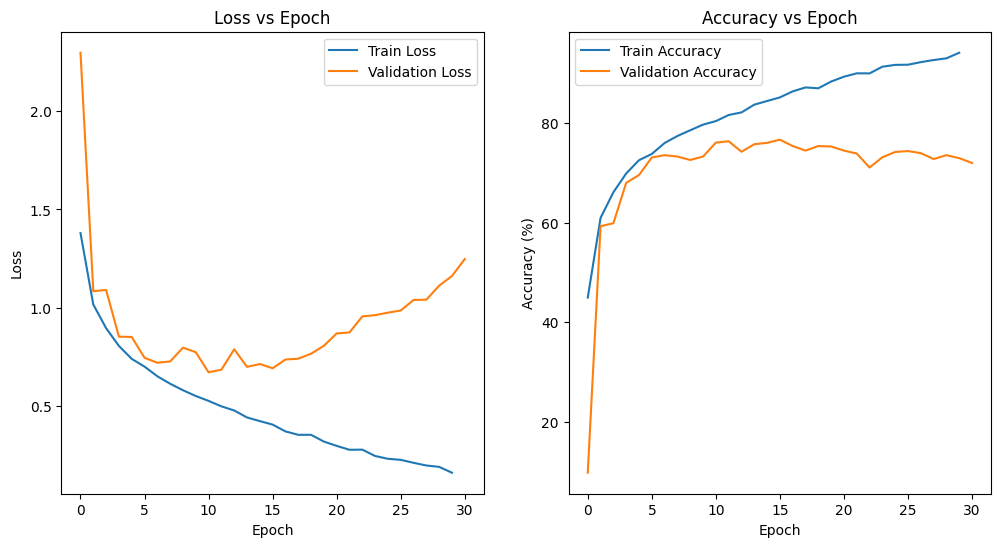

In [12]:
# Plot training loss and accuracy over epochs
plt.figure(figsize=(12, 6))

# Training Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Training Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.title("Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.show()


- Initial very fast improvement in accuracy
- Begins to slow down above ~ 50%
- Training accuracy continues to improve
    - Expect this would continue up to ~ 100% as the model overfits
- Validation accuracy is more variable
    - We see the best validation accuracy actually came from 16th epoch
    - As model continues to improve to match training data, it will overfit, and no longer generalises well, decreasing the accuracy of the validation set.

### (e) continued

Test Accuracy: 41.09%


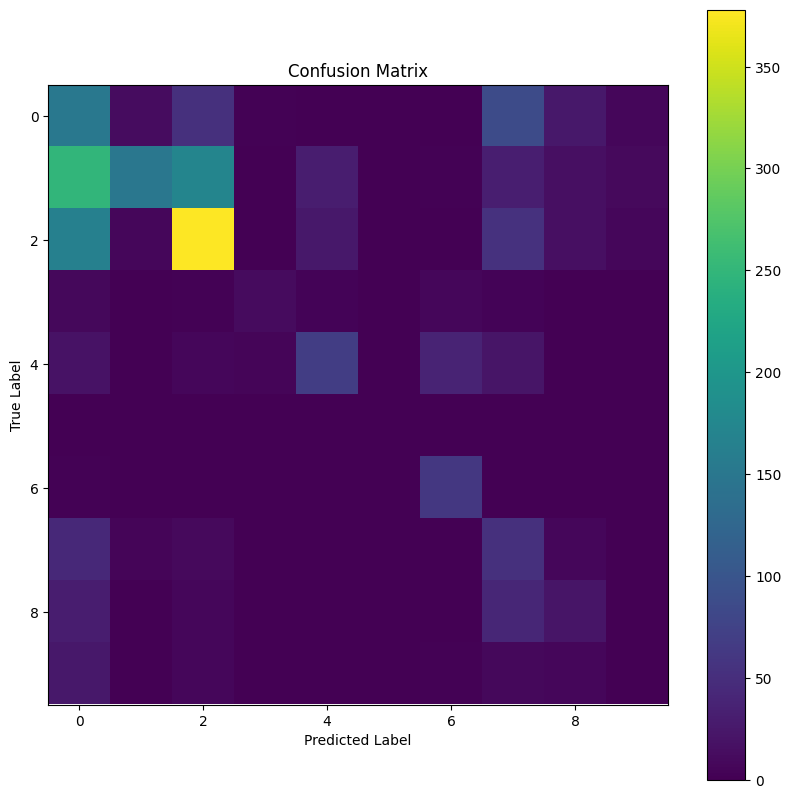

In [20]:
# TODO: Evaluate the best validation model on the test set and create a confusion matrix
from sklearn.metrics import confusion_matrix

# Load the best model
best_model = GalaxyCNN()
best_model.load_state_dict(torch.load("best_model_epoch_16.pth"))

# Evaluate the best model on the test set
best_model.eval()
test_corrects = 0
test_samples = 0
predictions = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = best_model(inputs)
        test_corrects += (outputs.argmax(1) == labels).sum().item() # Check if predictions are correct
        test_samples += labels.size(0)
        
        predictions.extend(outputs.argmax(1).tolist())
        true_labels.extend(labels.tolist())

# Calculate the test accuracy
test_accuracy = test_corrects / test_samples * 100
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Create the confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(conf_matrix, cmap='viridis')
plt.colorbar()
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### (f) Rotational invariance

In [22]:
def rot_90(image):
    return image.rot90(1, [2, 3])

def rot_180(image):
    return image.rot90(2, [2, 3])

def rot_270(image):
    return image.rot90(3, [2, 3])

def apply_rotations(tensor, layer):
            rotations = [tensor, rot_90(tensor), rot_180(tensor), rot_270(tensor)]
            return sum(layer(rot) for rot in rotations) / len(rotations)

In [ ]:
# Two options

# Option 1: Create a new dataset with rotated images
rot_images = torch.cat([norm_images, rot_90(norm_images), rot_180(norm_images), rot_270(norm_images)], dim=0)
rot_labels = torch.cat([labels, labels, labels, labels], dim=0)

# Option 2: Adjust the CNN to be rotation invariant

class GalaxyCNN_rot(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=5)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 14 * 14, 64)
        self.fc2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        answer = self.forward_worker(x)
        answer += self.forward_worker(rot_90(x))
        answer += self.forward_worker(rot_180(x))
        answer += self.forward_worker(rot_270(x))
        return answer / 4

    def forward_worker(self, x):
        # Forward pass
        # Block 1
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        # Block 2
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        # Block 3
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        # Output layer
        x = self.output(x)
        return x
    

In [ ]:
# To extend to general set of rotations:

from torchvision.transforms.functional import rotate

def rotate_image(image, angle):
    """
    Rotates the given image tensor by the specified angle.

    Args:
        image (Tensor): The input image tensor with shape (C, H, W).
        angle (float): The rotation angle in degrees (counter-clockwise).

    Returns:
        Tensor: The rotated image tensor.
    """
    return rotate(image, angle)



class GalaxyCNN_rot(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=5)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 14 * 14, 64)
        self.fc2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Example: Rotate by arbitrary angles
        angle_invariance = 20 # Replace as needed
        angles = torch.arange(0, 360, angle_invariance, dtype=torch.float32)
        rotations = [rotate_image(x, angle) for angle in angles]
        answer = sum(self.forward_worker(rot) for rot in rotations) / len(rotations)
        return answer
        
    
    def forward_worker(self, x):
        # Forward pass
        # Block 1
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        # Block 2
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        # Block 3
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        # Output layer
        x = self.output(x)
        return x


## 3 Positional Encoding

$ E \in \mathbb{R}^{p\times n} $

$ E_{(2k), i} = \sin\left(i \cdot \exp\left(-\frac{2k \cdot \log(10000)}{p}\right)\right) $

$ E_{(2k+1), i} = \cos\left(i \cdot \exp\left(-\frac{2k \cdot \log(10000)}{p}\right)\right) $

#### (a)

$$ S = K^TQ  $$

Addition: 

$$ K = Q = X + E \\
K^TQ = (X + E)^T(X + E)\\
= X^TX + E^TX + X^TE + E^TE $$

Concatenation:

$$ K = Q = \begin{bmatrix}
           X \\
           E \\
           \end{bmatrix}\\

S =       \begin{bmatrix}
           X^T & E^T \\
           \end{bmatrix}
           \begin{bmatrix}
            X\\ 
             E\\
            \end{bmatrix}\\

\\

S = X^TX +  E^TE $$


No cross terms from concatenation





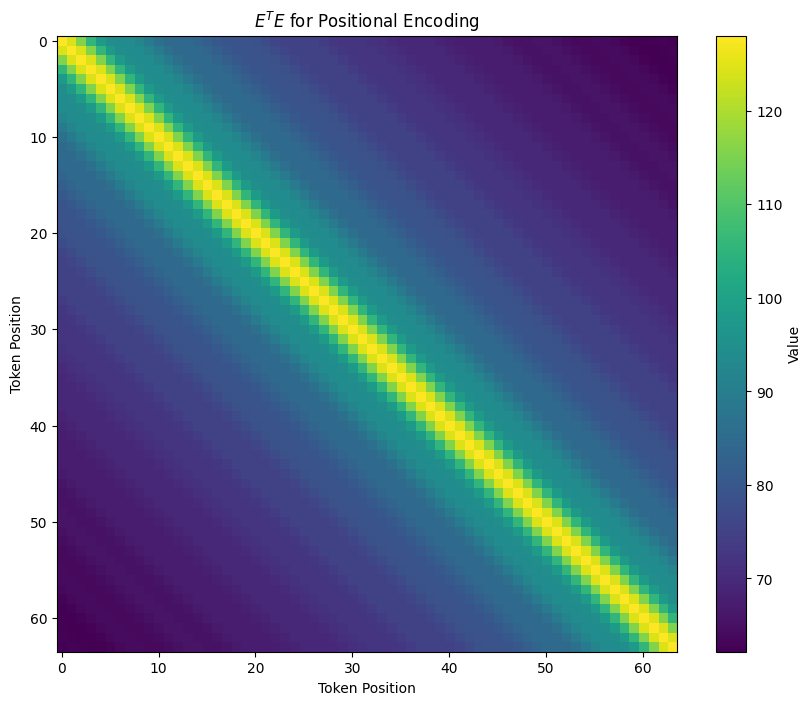

In [15]:
# Implementing encoding as defined above

def positional_encoding(p, n):
    """
    Generate the positional encoding matrix E for p-dimensional embeddings over n tokens.
    """
    E = np.zeros((p, n))
    for k in range(p // 2):  # Iterate over half the embedding dimension (p/2)
        for i in range(n):  # Iterate over token positions
            factor = np.exp(-2 * k * np.log(10000) / p)
            E[2 * k, i] = np.sin(i * factor)  # Even indices
            E[2 * k + 1, i] = np.cos(i * factor)  # Odd indices
    return E

# Parameters
p = 256  # Embedding dimension
n = 64   # Number of tokens

# Generate positional encoding
E = positional_encoding(p, n)

# Compute E^T E
ETE = E.T @ E

# Plot ETE
plt.figure(figsize=(10, 8))
plt.imshow(ETE, cmap='viridis', aspect='auto')
plt.colorbar(label='Value')
plt.title(r"$E^T E$ for Positional Encoding")
plt.xlabel("Token Position")
plt.ylabel("Token Position")
plt.show()


- We observe that the matrix is strongly diagonal - positional embeddings most similar to themselves.
- Observe an off-diagonal cyclic pattern - this must originate from the nature of sin and cos functions and how the values overlap.
- The cyclic patterns decay with distance, again reinforcing similarity between near embeddings.

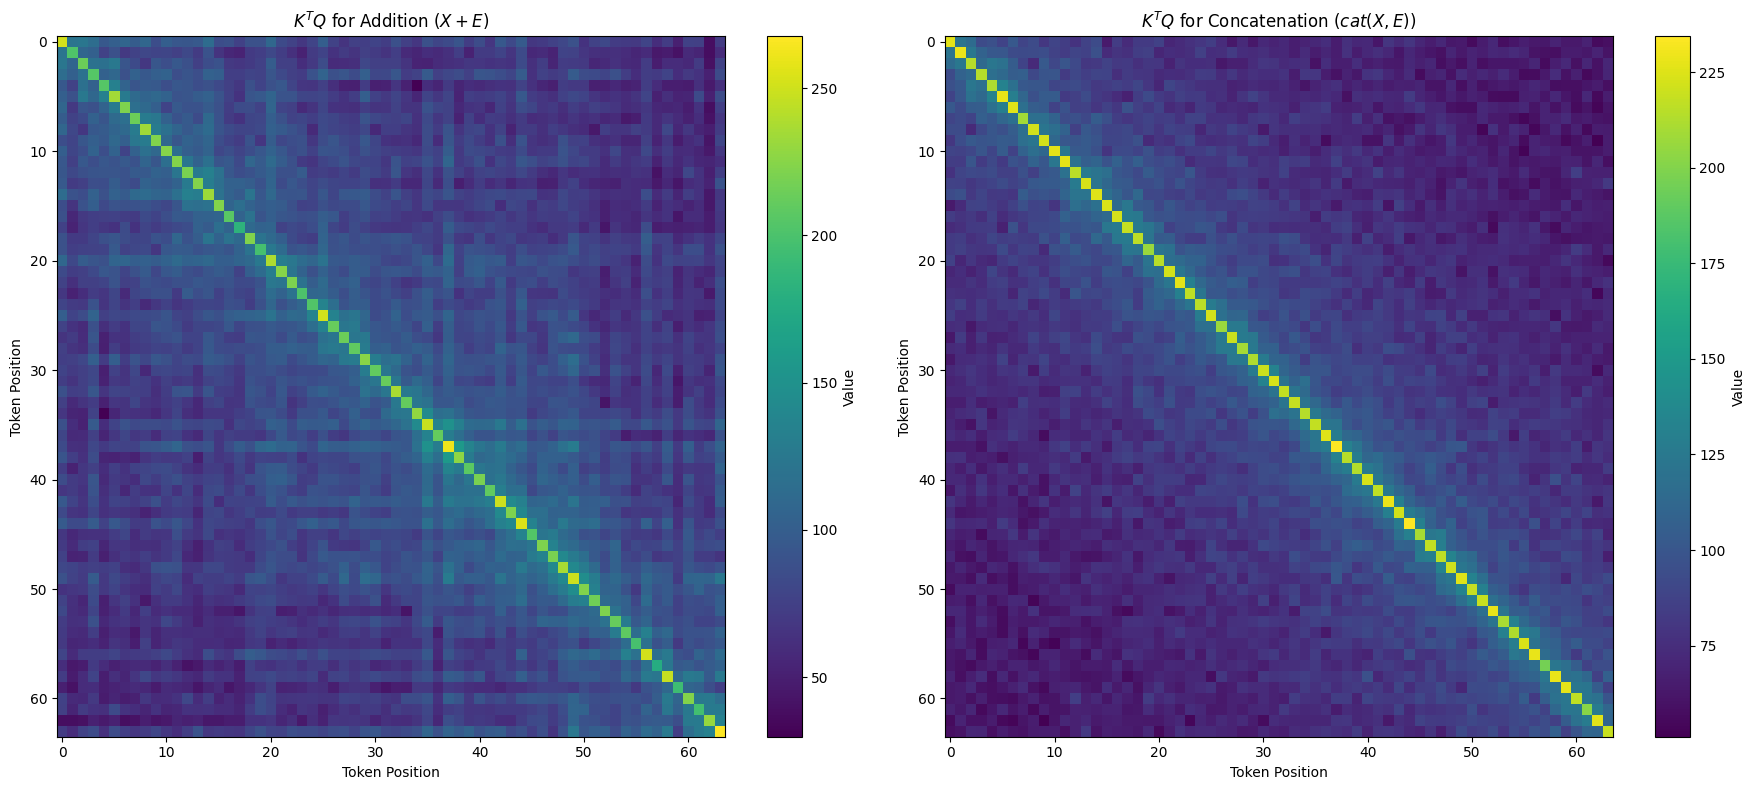

In [16]:
# Parameters
p = 256  # Embedding dimension
n = 64   # Number of tokens

# Generate positional encoding
E = positional_encoding(p, n)

# Generate random features with the same variance as the positional encoding
np.random.seed(42)  # For reproducibility
random_features = np.random.normal(0, np.std(E), size=(p, n)) #Same var

# Case 1: K = Q = X + E (Addition)
K_add = random_features + E  # Combine features and positional embeddings via addition
Q_add = K_add
S_add = K_add.T @ Q_add  # Compute K^T Q

# Case 2: K = Q = cat(X, E) (Concatenation)
K_cat = np.vstack((random_features, E))  # Combine features and positional embeddings via concatenation
Q_cat = K_cat
S_cat = K_cat.T @ Q_cat  # Compute K^T Q

# Plot S_add and S_cat
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot for addition
im1 = axes[0].imshow(S_add, cmap='viridis', aspect='auto')
axes[0].set_title(r"$K^T Q$ for Addition ($X + E$)")
axes[0].set_xlabel("Token Position")
axes[0].set_ylabel("Token Position")
plt.colorbar(im1, ax=axes[0], label="Value")

# Plot for concatenation
im2 = axes[1].imshow(S_cat, cmap='viridis', aspect='auto')
axes[1].set_title(r"$K^T Q$ for Concatenation ($cat(X, E)$)")
axes[1].set_xlabel("Token Position")
axes[1].set_ylabel("Token Position")
plt.colorbar(im2, ax=axes[1], label="Value")

plt.tight_layout()
plt.show()


Both methods continue to show the self similarity.

Addition combines the information from X and E early on, before processing, whereas Concatenation is able to preserve the respective information.

This means that there is more mixing in addition

#### (d)

$$ X \in S_X, E \in S_E\\
\text{Where dim}(S_X), \text{dim}(S_E) << n $$

Addition:
$$ K = Q = X + E \\
S_K = S_X \cup S_E $$


Concatentaion:
Also relatively small compared to larger space?
